# Prework

## Import packages and data

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
import statsmodels.api as sm
from math import sqrt as math_sqrt
from sklearn.metrics import mean_squared_error
import pickle
import math
import random
import sys
from tqdm import tqdm

#Import custom modules
sys.path.append('../')
from utils.utils import *

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.4.1
Eager execution: True


## Load data

In [3]:
training_data, testing_data, testing_index = load_data()

In [4]:
countries, no_features, feature_names, years, months, weekdays, hours = load_data_information()

## Adjust data format

In [5]:
# Extracts features, year, etc. from whole data
def change_format(input_data):
    #Extract year from data matrix
    year_w = input_data[:,:,0:1]
    #Extract weekday from data matrix
    weekday_w = input_data[:,:,1:2]
    #Extract hour from data matrix
    hour_w = input_data[:,:,2:3]
    #Extract country from data matrix
    country_w = input_data[:,0:1,3]   
    #Extract month from data matrix
    month_w = input_data[:,:,4:5]
    #Extract features from matrix
    features_w = input_data[:,:,5:5+no_features]
    #Extract matrix of missing values from data matrix
    miss_vals_w = input_data[:,:,-no_features-6:-6]
    #Extract pos enc from data matrix
    pos_enc_w = input_data[:,:,-6:]


    #Prepare format for features
    features_tf = np.reshape(features_w, [features_w.shape[0], -1, 1])
    miss_vals_tf = np.reshape(miss_vals_w, [features_w.shape[0], -1, 1])
    pos_enc_tf = np.reshape(tf.transpose(np.repeat(np.reshape(pos_enc_w, [pos_enc_w.shape[0], pos_enc_w.shape[1], pos_enc_w.shape[2], 1]), no_features, axis = 3), perm=[0,1,3,2]),[pos_enc_w.shape[0],-1,pos_enc_w.shape[2]])
    feature_nr_tf = np.repeat(np.reshape(np.repeat(np.reshape(np.array(range(no_features)),[1,-1]), input_data.shape[1], axis = 0),[1,-1]), input_data.shape[0], axis = 0)
    
    #Reshape other features
    hour_tf = np.reshape(np.repeat(hour_w, no_features,axis=2),[input_data.shape[0],-1])
    year_tf = np.reshape(np.repeat(year_w, no_features,axis=2),[input_data.shape[0],-1])
    weekday_tf = np.reshape(np.repeat(weekday_w, no_features,axis=2),[input_data.shape[0],-1])
    month_tf = np.reshape(np.repeat(month_w, no_features,axis=2),[input_data.shape[0],-1])

    
    

    return features_tf, miss_vals_tf, pos_enc_tf, country_w, year_tf, weekday_tf, hour_tf, feature_nr_tf
#testing
features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(training_data[18:19])

Anpassen der Anzahl der missing values und welches feature gemasked werden soll

Features: PV-12 ; Wind-Onshore-14

In [6]:
number_miss_vals = no_features*12#24 # number of missing values per day (maximum is features masked times 24)
masked_feature = 12 # country and year do not count
all_masked = 1# if all inserted features should be masked randomly (if 1, masked feature is not needed)

Funktion um Maske über Features zu legen

In [7]:
def mask_features(features, miss_vals):    
    mask = np.zeros(features.shape)
    for sample in range(features.shape[0]):
        if all_masked == 1:        
            #Draw number of missing values from Binomial distribution
            p = np.random.uniform(0.2,0.8)
            n_miss_vals = np.random.binomial(n=24*no_features, p = p)
            idx_all = list(range(24*no_features)) # all features masked
        else:
            n_miss_vals = number_miss_vals
            idx_all = list(range(masked_feature,24*no_features,no_features)) # just one feature masked
        np.random.shuffle(idx_all)
        idx = idx_all[:n_miss_vals]
        for mv in range(n_miss_vals):
            #Insert mask at the middle day of the week
            mask[sample, (2*24)*no_features + idx[mv]] = 1

    features_masked = np.array(features)
    features_masked[mask==1] = 0

    miss_vals_masked = np.array(miss_vals)
    miss_vals_masked[mask==1] = 1
    

    return features_masked, miss_vals_masked, mask
features_masked, miss_vals_masked, mask = mask_features(features, miss_vals)

## Create validation split and fetch data

Create function for validation split

In [8]:
def val_split(data, split = 0.2):
    size = int(data.shape[0]*split)
    index = data.shape[0]
    split_index = random.choices(range(index),k=size)
    data_val = data[split_index]
    data_train = np.delete(data,split_index,axis=0)
    
    return data_train, data_val

Define batch size and create preprocessing for testing data

# Model

## Define Model

In [9]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        mask = tf.cast(mask, dtype = tf.float32)
        scaled_attention_logits = scaled_attention_logits + (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights= scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [11]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [12]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, q, kv, training, mask):

        attn_output, attention_weights = self.mha(q, kv, kv, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(attn_output+q)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attention_weights

In [13]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        
    def call(self, q, kv, training, mask):
        for i in range(self.num_layers):
            q, attention_weights = self.enc_layers[i](q, kv, training, mask)

        return q, attention_weights

Heuristik für Anzahl Embedding Ausgänge

min(600, round(1.6 * (config["vocab_size"] + 1) ** .56))

In [14]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, no_features, rate=0.1):
        super(Transformer, self).__init__()

        #Encoding Layers
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, rate)
        
        #Embedding layers
        self.embedding_country = tf.keras.layers.Embedding(countries.shape[0], 9)
        self.embedding_year = tf.keras.layers.Embedding(years.shape[0], 4) 
        self.embedding_feat = tf.keras.layers.Embedding(no_features, 7)
        

        #Dense Layers
        self.first_layer = tf.keras.layers.Dense(d_model)
        self.final_layer = tf.keras.layers.Dense(1)
    
    def call(self, country, year, weekday, hour, features_masked, miss_vals_masked, 
            pos_enc, feature_nr, training, enc_padding_mask = None):
          
        #Embeddings
        country_emb = self.embedding_country(country)
        year_emb = self.embedding_year(year)
        #weekday_emb = self.embedding_weekday(weekday)
        #hour_emb = self.embedding_hour(hour)
        feat_emb = self.embedding_feat(feature_nr)
        
        
        # concatenation (embeddings plus features)
        kv = tf.concat([pos_enc, 
                        tf.repeat(country_emb, pos_enc.shape[1], axis = 1),
                        year_emb, 
                        #weekday_emb, 
                        #hour_emb,
                        features_masked, miss_vals_masked, feat_emb], axis = 2)
        kv = self.first_layer(kv)

        q = tf.concat([pos_enc, 
                       tf.repeat(country_emb, pos_enc.shape[1], axis = 1),
                       year_emb, 
                       #weekday_emb,  
                       #hour_emb,
                       features_masked, miss_vals_masked, feat_emb], axis = 2)
        q = self.first_layer(q)
        
        enc_output, attention_weights = self.encoder(q, kv, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        final_output = self.final_layer(enc_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

## Define Loss and Matrices

In [15]:
def loss_function(real, pred, mask):
    real = real[mask==1]
    pred = pred[mask==1]
    real = tf.dtypes.cast(real, tf.float32)
    error = real-pred
    error = tf.square(error)
    loss = tf.math.sqrt(tf.math.reduce_mean(error))*1000 # sonst so klein ;-)
    return loss

In [16]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

## Adjust Hyperparameters

In [17]:
num_layers = 4
d_model = 128
dff = 2*d_model
num_heads = 1
dropout_rate = 0.1
learning_rate = 0.001

In [18]:
BATCH_SIZE = 20
optimizer = tf.keras.optimizers.Adam(learning_rate)

## Training process

In [19]:
def train_step(country, year, weekday, hour, features, features_masked, miss_vals_masked, 
               pos_enc, feature_nr, mask):

    training = True

    with tf.GradientTape() as tape:
        pred, attention_weights = transformer(country, year, weekday, hour, features_masked, miss_vals_masked, 
                                              pos_enc, feature_nr,  training)

        loss = loss_function(features, pred, mask)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    return loss, pred, attention_weights

In [20]:
transformer = Transformer(num_layers, d_model, num_heads, dff, no_features, rate=dropout_rate)

### Checkpointing

Checkpoint manager kann genutzt werden um trainierte Modelle zu speichern und zu laden

In [21]:
checkpoint_path = "./checkpoints/transformer"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [22]:
class Scheduler:
    def __init__(self, checkpoint, checkpoint_manager, learning_rate, patience = 2, delta = 5, fine_tuning = False, min_epochs = 20):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.checkpoint_manager = checkpoint_manager
        self.checkpoint = checkpoint
        self.learning_rate = learning_rate
        self.fine_tuning = fine_tuning
        self.min_epochs = min_epochs

    def __call__(self, metric, epoch):
        #Check if score is not initialized
        if self.best_score is None:
            self.best_score = metric
            return (False,self.learning_rate)
        
        #Check for minimum amount of epochs
        if epoch <= self.min_epochs:
            if metric <= self.best_score + self.delta:
                self.best_score = metric
                ckpt_save_path = self.checkpoint_manager.save()
                print(f'Saving checkpoint at {ckpt_save_path}')
            return (False, self.learning_rate)
        
        #If score is worse than before
        if metric > self.best_score + self.delta:
            self.counter += 1
            #If score is still in patience
            if self.counter >= self.patience:
                #If fine tuning is already running
                if self.fine_tuning==True:
                    print("Training finished")
                    return (True,self.learning_rate)
                else:
                    self.fine_tuning=True
                    self.counter = 0
                    self.learning_rate = self.learning_rate/2
                    self.patience += 2
                    if self.checkpoint_manager.latest_checkpoint:
                        self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
                        print('Latest checkpoint restored!!')
                    print(f'Learning rate adjusted to {np.round(self.learning_rate,6)}')
                    self.patience +=2
                    return (False,self.learning_rate)
            else:                
                return (False,self.learning_rate)
        #If score is better   
        else:
            self.best_score = metric
            ckpt_save_path = self.checkpoint_manager.save()
            print(f'Saving checkpoint at {ckpt_save_path}')
            self.counter = 0        
            return (False,self.learning_rate)

In [23]:
scheduler = Scheduler(ckpt, ckpt_manager, learning_rate, patience = 5, delta = 5, fine_tuning=False)

## Tensorboard

In [58]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [59]:
log_dir = "logs/transformer/"
train_writer = tf.summary.create_file_writer(log_dir)

In [60]:
%tensorboard --logdir logs/transformer --port=8080

Reusing TensorBoard on port 8080 (pid 33040), started 0:05:25 ago. (Use '!kill 33040' to kill it.)

## Training process

In [64]:
EPOCHS = 50
losses = [[],[]]

for epoch in range(EPOCHS):    

    #Create a smaller sample of the training data for computational purposes
    #Only while testing the model
    #index = random.choices(range(training_data.shape[0]),k=1000)
    #train_res = training_data[index]
    
    #Shuffle training data
    #np.random.shuffle(training_data)
    
    # split train data in train and val sets
    samples_train, samples_val = val_split(training_data,split=0.2)

    # create train dataset
    data_train = tf.data.Dataset.from_tensor_slices(samples_train)
    data_train = data_train.cache()
    data_train = data_train.shuffle(samples_train.shape[0]).padded_batch(BATCH_SIZE) #, drop_remainder=True
    data_train = data_train.prefetch(tf.data.experimental.AUTOTUNE)

    # create val dataset 
    data_val = tf.data.Dataset.from_tensor_slices(samples_val)
    data_val = data_val.cache()
    data_val = data_val.shuffle(samples_val.shape[0]).padded_batch(BATCH_SIZE) #, drop_remainder=True
    data_val = data_val.prefetch(tf.data.experimental.AUTOTUNE)

    train_loss.reset_states()
    val_loss.reset_states()
    
    train_counter = 0
    running_train_loss = 0  
    # train the model
    for (batch, data_inp) in tqdm(enumerate(data_train), desc = "Loading..", total = int(np.ceil(samples_train.shape[0]/BATCH_SIZE))):
        train_counter += 1
        features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(data_inp)
        features_masked, miss_vals_masked, mask = mask_features(features, miss_vals)

        loss, pred, attention_weights = train_step(country, year, weekday, hour, features, features_masked,
                                                miss_vals_masked, pos_enc, feature_nr, mask)
        
        #Save loss to tensorboard
        running_train_loss += loss
        if train_counter % 100 == 0:
            with train_writer.as_default():
                tf.summary.scalar('train_loss', running_train_loss/100, step=(epoch*len(samples_train)+train_counter*BATCH_SIZE))
                running_train_loss = 0

        train_loss(loss)
    losses[0].append(train_loss.result())


    # validation data calculation
    for (batch, data_inp) in enumerate(data_val):
        features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr= change_format(data_inp)
        features_masked, miss_vals_masked, mask = mask_features(features, miss_vals)

        pred,_ = transformer(country, year, weekday, hour, features_masked, miss_vals_masked,
                            pos_enc, feature_nr, training=False)
        loss = loss_function(features, pred, mask)
        val_loss(loss)
    losses[1].append(val_loss.result())
    
    #Save validation data to log
    with train_writer.as_default():
        tf.summary.scalar('val_loss', val_loss.result(), step=((epoch+1)*len(samples_train)))

    print ('Epoch {} - Loss {:.4f} val_Loss {:.4f} '.format(
        epoch + 1, train_loss.result(), val_loss.result()))

    #Check early stopping and checkpointing
    stopping, learning_rate = scheduler(float(val_loss.result()), epoch)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    if stopping == True:
        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print("Training finished")      
        break

Loading..:   3%|██▏                                                                  | 69/2161 [00:17<08:50,  3.94it/s]


KeyboardInterrupt: 

In [32]:
transformer.summary()

Model: "transformer_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  529920    
_________________________________________________________________
embedding_6 (Embedding)      multiple                  261       
_________________________________________________________________
embedding_7 (Embedding)      multiple                  24        
_________________________________________________________________
embedding_8 (Embedding)      multiple                  91        
_________________________________________________________________
dense_76 (Dense)             multiple                  3712      
_________________________________________________________________
dense_77 (Dense)             multiple                  129       
Total params: 534,137
Trainable params: 534,137
Non-trainable params: 0
_______________________________________________

### Plot losses

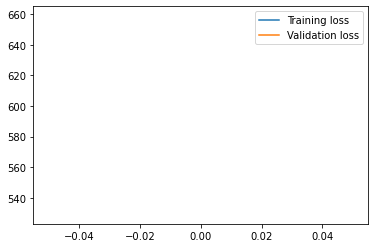

In [33]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(["Training loss","Validation loss"])

# Predict new data

In [30]:
transformer.load_weights('weights/transformer/transformer_weights')

## Create test data

Modell wird noch einmal auf finalen Testdatensatz angewandt. Dann kann der Testdatensatz extrahiert werden um ihn für die anderen Modelle zum Benchmarking zu benutzen.

In [31]:
#BATCH_SIZE = 32
data_test = tf.data.Dataset.from_tensor_slices(testing_data)
data_test = data_test.cache()
data_test = data_test.padded_batch(BATCH_SIZE)
data_test = data_test.prefetch(tf.data.experimental.AUTOTUNE)

# Developing process: Testing mask

In [32]:
#Function for testing mask
def get_testing_mask(features, miss_vals, mask):
    mask = mask.reshape(features.shape)
    features_masked = np.array(features)
    features_masked[mask==1] = 0

    miss_vals_masked = np.array(miss_vals)
    miss_vals_masked[mask==1] = 1

    
    return features_masked, miss_vals_masked, mask

## Load and predict testing masks

In [34]:
for p in np.round(np.arange(0.1,1,0.1),1):
    testing_mask=np.load("../evaluation/masks/testing_mask_{}.npy".format(p))
    
    #Create empty arrays for Results
    values_act=np.array([])
    prediction = np.array([])

    for (batch, data_inp) in tqdm(enumerate(data_test), desc = "Loading..", total = int(np.ceil(testing_data.shape[0]/BATCH_SIZE))):
        features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr= change_format(data_inp)
        features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE])

        pred,attention_weights = transformer(country, year, weekday, hour, features_masked, miss_vals_masked, 
                            pos_enc, feature_nr, training=False)

        #Add real values and prediction to dataframe
        values_act = np.append(values_act,features[mask==1].flatten())
        prediction = np.append(prediction,pred[mask==1].numpy())
        
    #Calculate mse
    mse = mean_squared_error(values_act,prediction)
    print(mse)
    
    #Save prediction
    np.save("../data/predictions/transformer_pred_{}".format(p),prediction)

Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:20<00:00, 12.73it/s]


0.015422470266553029


Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:20<00:00, 12.94it/s]


0.016661310697099942


Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:23<00:00, 10.97it/s]


0.016855987827722647


Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:20<00:00, 12.56it/s]


0.018851196446613743


Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:20<00:00, 12.38it/s]


0.020926213949660575


Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:20<00:00, 12.65it/s]


0.023508593595606964


Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:20<00:00, 12.39it/s]


0.027032873230646955


Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:21<00:00, 12.33it/s]


0.03423005040619691


Loading..: 100%|█████████████████████████████████████████████████████████████████████| 259/259 [00:21<00:00, 12.14it/s]

0.045837955661024624


In [36]:
#Load testing mask
testing_mask=np.load("../data/evaluation/testing_mask_test.npy")
#Create empty arrays for Results
prediction = np.array([])
values_act=np.array([])


for (batch, data_inp) in tqdm(enumerate(data_test), desc = "Loading..", total = int(np.ceil(testing_data.shape[0]/BATCH_SIZE))):
    features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(data_inp)
    features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE])

    pred,attention_weights = transformer(country, year, weekday, hour, features_masked, miss_vals_masked, 
                        pos_enc, feature_nr, training=False)

    #Add real values and prediction to dataframe
    values_act = np.append(values_act,features[mask==1].flatten())
    prediction = np.append(prediction,pred[mask==1].numpy())

#Print mse
mse = mean_squared_error(values_act,prediction)
print(mse)

np.save("../data/predictions/transformer_pred_test",prediction)

Loading..:   0%|                                                                               | 0/259 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 28800 into shape (20,1560,1)